<a href="https://colab.research.google.com/github/zhangxinqiao314/brightfield-image-segmentation/blob/main/BF_environmental_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

## Install packages

In [6]:
# we will need the sidpy package and pyNSID and SciFIreaders
!pip install sidpy;
#git+https://github.com/pycroscopy/sidpy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 94 kB 3.4 MB/s 
     |████████████████████████████████| 837 kB 54.1 MB/s 
     |████████████████████████████████| 793 kB 55.3 MB/s 
     |████████████████████████████████| 481 kB 71.0 MB/s 
     |████████████████████████████████| 1.1 MB 53.4 MB/s 
     |████████████████████████████████| 596 kB 70.3 MB/s 
     |████████████████████████████████| 140 kB 75.3 MB/s 
     |████████████████████████████████| 381 kB 73.6 MB/s 
  Created wheel for cytoolz: filename=cytoolz-0.11.2-cp37-cp37m-linux_x86_64.whl size=1236741 sha256=8c398866cb21f534d1dab8a3071c13efc18e735e0eb69a2b87d7b0663189098f
  Stored in directory: /root/.cache/pip/wheels/38/70/71/ca13ea3d36ccd0b3d0ec7d7a4ca67522048d695b556bba4f59
Successfully built cytoolz
  Attempting uninstall: prompt-toolkit
    Found existing installation: prompt-toolkit 1.0.18
    Uninstalling prompt-toolkit-1.0.18:
     

In [7]:
!pip install pyNSID;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!pip install pyUSID;

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 66 kB 3.6 MB/s 


In [9]:
#MAKE SURE TO RESTART RUNTIME AFTER RUNNING THIS CELL!
!pip install pycroscopy=='0.61.0-alpha';

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 10.0 MB/s 
     |████████████████████████████████| 154 kB 66.1 MB/s 


## Import

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
cd /content/drive/MyDrive/BTO_4DSTEM/BF

/content/drive/MyDrive/BTO_4DSTEM/BF


In [3]:
# General utilities:
import os
import sys
from time import time
import imageio
from skimage.color import rgb2gray


import numpy as np
import sidpy
import matplotlib.pyplot as plt
import h5py
import pyNSID
print('sidpy version: ', sidpy.__version__)


from skimage.color import rgb2gray
import imageio

from tqdm import tqdm

from scipy import ndimage

#import the package
import pycroscopy as px
from pycroscopy.image import ImageWindowing

import matplotlib.pyplot as plt
import numpy as np
from skimage.filters import difference_of_gaussians, window
from scipy.fft import fftn, fftshift
import torch
from scipy import ndimage
from skimage.transform import rescale
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pycroscopy as px
from pycroscopy.image import ImageWindowing

from pdb import set_trace as bp

import re
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import dask.array as da

sidpy version:  0.0.9


## functions

In [4]:
def plot_window(x,y,image,windows):
    '''
    plot the filtered image, transform, and window
    x: x index
    y: y index
    image: image you generated windows from
    windows: dataset from h5 file generated from plotting windows
    '''
    
    
    fig = plt.figure(figsize=(16,8))
    gs = fig.add_gridspec(2, 3)
    axs = []
    axs.append( fig.add_subplot(gs[:,0:2]) ) # large subplot (2 rows, 2 columns)
    axs.append( fig.add_subplot(gs[0,2]) )   # small subplot (1st row, 3rd column)
    axs.append(fig.add_subplot(gs[1,2]))
    xi,yi = int((x+.5)*32),int((y+.5)*32)

    axs[0].set_title('Full Image')
    a1 = axs[0].imshow(image[:])
    rect = patches.Rectangle((xi+32,yi+32),64,64,linewidth=2, edgecolor='r', facecolor='none')
    axs[0].add_patch(rect)
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(a1, cax=cax, orientation='vertical', pad = 0.2)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

    fft = windows[x][y]
    axs[1].set_title('fft tile')
    a2 = axs[1].imshow((np.log(fft)))
    divider = make_axes_locatable(axs[1])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(a2, cax=cax, orientation='vertical', pad = 0.2)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

    # fft = dask.array.rechunk(fft,-1)
    # ifft = np.fft.ifft2(fft).real
    axs[2].set_title('unfiltered')
    a3 = axs[2].imshow(image[xi:xi+64,yi:yi+64],vmax=1.,vmin=0.)
    divider = make_axes_locatable(axs[2])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(a3, cax=cax, orientation='vertical', pad = 0.2)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

    plt.tight_layout()
    plt.show()

In [5]:
def NormalizeData(data):
    if np.max(data)==np.min(data): return data
    else: return (data - np.min(data)) / (np.max(data) - np.min(data))

def fft_transform(image):
    '''
    assert r.dtype==torch.float32, 'Suppose to be torch.float32, not '+str(r.dtype)
    '''  
    
    image = torch.tensor(image)
    out = torch.clone(image)
    img_fft = torch.fft.fft2(image, dim=(0,1))
    img_shift = torch.fft.fftshift(img_fft)
    out = np.log(np.abs(img_shift))
    
    # abnormal value
    out[out==-np.inf] = 0
    
    # scale to 0-1
    out =  (out * 1/out.max())
    return out.numpy()

In [6]:
def temp(e):
    if len(e)<8:
        return '-'+e[:-4].zfill(3)
    else:
        return '-0.png'

def get_temps(env):
    up = os.listdir(f'./{env}/Ramp_Up')
    up.sort(key=temp)
    up = list(map(lambda x:f'./{env}/Ramp_Up/'+x, up))

    down = os.listdir(f'./{env}/Ramp_Down')
    down.sort(key=temp,reverse=True)
    # down = down.map(function(val) {return '.'+val;})
    down = list(map(lambda x:f'./{env}/Ramp_Down/'+x, down))

    temps = up+down
    return temps

# 1. Windowing
You only need to do this section one time for each new dataset. I suggest commenting out this section when you are ready to start training the jVAE.

In [7]:
env = '3.Annealed' # name of folder with the original bright field images
combined = 'Combined_BF_Annealed_cropped.h5' # name of h5 file with cropped/filtered data, and fft images
emb = 'Annealed Embeddings.h5' # name of h5 file with embeddings
f = 'BF_jVAE_Annealed' # folder with saved checkpoints on embedding movies

In [8]:
# make list of file names for original bright field images

temps = get_temps(env)
t_len=len(temps)
t_len

43

## Apply gaussian filters and crop into square. Load into h5 file

In [22]:
# Roughly crop and apply gaussian filter on original image. 
# SKIP if you already made your h5 file


c1,c2,step = 200,300,1400, # x starting point, y starting point, window size. In total, image is 2048px

h = h5py.File(combined,'a') #put the name of the file you would like to use

if 'All' in h.keys(): 
  del h['All']
  h_write = h.create_dataset('All',(t_len,step,step),dtype='f4')
h_write=h['All']

if  'All_filtered' in h.keys(): 
  del h['All_filtered']
  h_writef = h.create_dataset('All_filtered',(t_len,step,step),dtype='f4')
h_writef=h['All_filtered']

for i,temp in enumerate(tqdm(temps)):
    im = rgb2gray(imageio.imread(temp))
#     im[1850:,:400]=0 ## get rid of the scale
    im1 = im[c1:c1+step,c2:c2+step] # crop
    
    h_write[i] = im1
    
    img_blur = ndimage.gaussian_filter(im1,20)
    im1=im1-img_blur
    im1=NormalizeData(im1)

    h_writef[i] = im1
    
h.close()

100%|██████████| 43/43 [00:26<00:00,  1.60it/s]


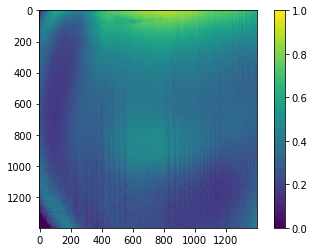

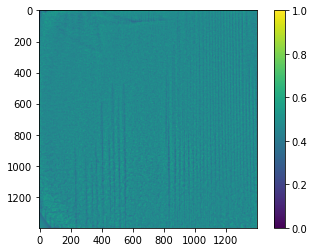

In [23]:
hf = h5py.File(combined,'a')
i=-1

plt.imshow(hf['All'][i])
plt.colorbar()
plt.show()
plt.imshow(hf['All_filtered'][i])
plt.colorbar()
plt.show()

## use pycroscopy to create windows and apply fft on original BF image

In [24]:
# make the windowing object

import re
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import dask.array as da

images=hf['All_filtered'][:]

# Do some sliding FFT
parms_dict = {}

# Window parameters: you can tune these to make image higher resolution. 
# Smaller step size will result in higher resolution,
parms_dict['window_step_x'] = 32
parms_dict['window_step_y'] = 32
parms_dict['window_size_x'] = 128
parms_dict['window_size_y'] = 128

#Mode parameters
parms_dict['mode'] = 'fft' # want data in reciprocal space for jVAE
parms_dict['fft_mode'] = 'abs' # return absolute values of fft
parms_dict['interpol_factor'] = 2.3 
parms_dict['zoom_factor'] = 2 #NOTE: Must be integer

iw = ImageWindowing(parms_dict)

image test is shape (128, 128)
image zoomed is shape (64, 64)
image zoomed interpol is shape (147, 147)


In [28]:
# write windows into a file
# This may take a very long time! up to 30 minutes.
from skimage.transform import resize

h = h5py.File(combined,'a')

grp = '128_fft_windows'
dset = '128_fft_windows_dataset'
logset = '128_fft_windows_logdata'

if grp not in h.keys(): h_windows=h.create_group(grp)
h_windows=h[grp]

for i,image in enumerate(tqdm(images)):
    data_image = sidpy.Dataset.from_array(image)
    windows = iw.MakeWindows(data_image)
    title = re.split('/|\.',temps[i])[-3]+'_'+re.split('/|\.',temps[i])[-2]
    
    if f'filler' in h[grp]: del h[grp][f'filler']
    meas_grp = h[grp].create_group(f'filler')
    
    pyNSID.hdf_io.write_nsid_dataset(windows, meas_grp, main_data_name="windows");    
    a,b,x,y = h[grp]['filler']['windows']['windows'].shape
    data = h[grp]['filler']['windows']['windows'][:].reshape(-1,x,y)
    
    if dset not in h_windows.keys(): d_windows=h[grp].create_dataset(dset,shape=(t_len*a*b,x,y))
    d_windows=h[grp][dset]
    d_windows[i*a*b:(i+1)*a*b] = data

    if logset not in h_windows.keys(): logdata= h[grp].create_dataset(logset,shape=(t_len*a*b,1,128,128),dtype='f4')
    logdata=h[grp][logset]
    data = data.reshape(-1,1,x,y)
    data = resize(data,(a*b,1,128,128))
    data = np.log(data+1)
    data[data>5]=5
    logdata[i*a*b:(i+1)*a*b] = data
    
#     print(h[grp].keys())

h.close()

100%|██████████| 43/43 [26:57<00:00, 37.62s/it]


## Read from h5 and reshape

In [ ]:
hf = h5py.File(combined, 'a')
hf.keys()

<KeysViewHDF5 ['128_fft_windows', 'All', 'All_filtered']>

In [ ]:
data = hf['128_fft_windows']['128_fft_windows_dataset']

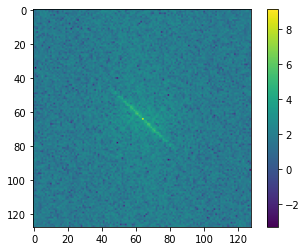

In [ ]:
plt.imshow(np.log(data[16][20][10]))
plt.colorbar()

In [ ]:
(t,a,b,x,y) = data.shape
t,a,b,x,y

(56, 46, 46, 128, 128)

# 2. jVae

## import

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/BTO_4DSTEM/BF

/content/drive/MyDrive/BTO_4DSTEM/BF


In [ ]:
#import hyperspy.api as hs
import os
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import torch
from torch.autograd import Variable
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, models
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Function
from collections import OrderedDict
import torch.nn as nn
import math
import torchvision.models as models
import torchvision.transforms as transforms
import pickle
import torch.autograd as autograd
import matplotlib.gridspec as gridspec
import h5py
from tqdm import tqdm
from scipy import ndimage as ndi
from skimage.feature import peak_local_max
from skimage import data, img_as_float
import cv2
from tqdm import tqdm
from os.path import join as pjoin
import glob as glob
from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

from IPython.core.debugger import Pdb

In [ ]:
from skimage.transform import resize

In [ ]:
import torchvision.transforms as T

In [ ]:
import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
import re

In [ ]:
# Take the name to set device
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-53012fa8-3b7f-d965-ab6c-64dfb015bb72)


In [ ]:
device = torch.device('cuda:0')

In [ ]:
env = '2.Oxygen' # name of folder with the original bright field images
combined = 'Combined_BF_Oxygen_cropped.h5' # name of h5 file with cropped/filtered data, and fft images
emb = 'Oxygen Embeddings.h5' # name of h5 file with embeddings
f = 'BF_jVAE_O' # folder with saved checkpoints on embedding movies

## Autoencoder model

In [ ]:
class conv_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(conv_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_2 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov1d_3 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
#         self.attention_1 = nn.MultiheadAttention(n_step, 1)
#         self.attention_2 = nn.MultiheadAttention(n_step, 1)
#         self.attention_3 = nn.MultiheadAttention(n_step, 1)
#         self.norm_1 = nn.LayerNorm([n_step])
#         self.norm_2 = nn.LayerNorm([n_step])
        self.norm_3 = nn.LayerNorm(n_step)
#        self.drop = nn.Dropout(p=0.2)
#         self.relu_1 = nn.ReLU()
#         self.relu_2 = nn.ReLU()
#         self.relu_3 = nn.ReLU()
        self.relu_4 = nn.ReLU()
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)        
        out = self.cov1d_2(out)
        out = self.cov1d_3(out)
        out = self.norm_3(out)        
        out = self.relu_4(out)
        out = out.add(x_input)
#        output = self.drop(x)
        
        return out

In [ ]:
class identity_block(nn.Module):
    def __init__(self,t_size,n_step):
        super(identity_block,self).__init__()
        self.cov1d_1 = nn.Conv2d(t_size,t_size,3,stride=1,padding=1,padding_mode = 'zeros')
#         self.attention_1 = nn.MultiheadAttention(n_step, 1)
        self.norm_1 = nn.LayerNorm(n_step)
#        self.drop = nn.Dropout(p=0.2)
        self.relu = nn.ReLU()
        
        
    def forward(self,x):
        x_input = x
        out = self.cov1d_1(x)
        out = self.norm_1(out)
        out = self.relu(out)

        
        return out

In [ ]:
class Encoder(nn.Module):
    def __init__(self,original_step_size,pool_list,embedding_size,conv_size):
        super(Encoder,self).__init__()
        
        blocks = []
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(nn.MaxPool2d(pool_list[0], stride=pool_list[0]))
        
        for i in range(1,number_of_blocks):
            original_step_size = [original_step_size[0]//pool_list[i-1],original_step_size[1]//pool_list[i-1]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(nn.MaxPool2d(pool_list[i], stride=pool_list[i])) 
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        original_step_size = [original_step_size[0]//pool_list[-1],original_step_size[1]//pool_list[-1]]
        
        input_size = original_step_size[0]*original_step_size[1]
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')

        self.relu_1 = nn.ReLU()

        self.dense1 = nn.Linear(input_size,embedding_size)
#         self.dense2 = nn.Linear(input_size,embedding_size)

        
    def forward(self,x):
#        x = x.transpose(1,2)
        out = x.view(-1,1,self.input_size_0,self.input_size_1)
#        x = self.average(x)
        out = self.cov2d(out)
        for i in range(self.layers):
            out = self.block_layer[i](out)
        out = self.cov2d_1(out)
#         print(out.shape)
        out = torch.flatten(out,start_dim=1)
#         print(out.shape)
#        print(x.shape)
#         x = x.transpose(1,2)
#        encode,(_,__) = self.lstm(x)
#        encode = encode[:,-1,:]
        out = self.dense1(out)   
        selection = self.relu_1(out)
#         out_std = self.dense2(out)
        
#         print(selection.shape)
        
        
        scale_1 = nn.Tanh()(out[:,0])*0.1+1
        scale_2 = nn.Tanh()(out[:,1])*0.1+1
        
        trans_1 = out[:,3]
        trans_2 = out[:,4]
        
        rotate = out[:,2]
        
        a_1 = torch.cos(rotate)
#       a_2 = -torch.sin(selection)
        a_2 = torch.sin(rotate)
        a_4 = torch.ones(rotate.shape).to(device)
        a_5 = rotate*0
        
        b1 = torch.stack((a_1,a_2), dim=1).squeeze()
        b2 = torch.stack((-a_2,a_1), dim=1).squeeze()
        b3 = torch.stack((a_5,a_5), dim=1).squeeze()
        rotation = torch.stack((b1, b2, b3),dim=2)
#         print(rotation.shape)
        
        c1 = torch.stack((scale_1,a_5), dim=1).squeeze()
        c2 = torch.stack((a_5,scale_2), dim=1).squeeze()
        c3 = torch.stack((a_5,a_5), dim=1).squeeze()
        scaler = torch.stack((c1, c2, c3),dim=2)

        d1 = torch.stack((a_4,a_5), dim=1).squeeze()
        d2 = torch.stack((a_5,a_4), dim=1).squeeze()
        d3 = torch.stack((trans_1,trans_2), dim=1).squeeze()
        translation = torch.stack((d1, d2, d3),dim=2)
        
        size_grid = torch.ones([x.shape[0],1,2,2])
        
        
        grid_1 = F.affine_grid(rotation.to(device), size_grid.size()).to(device)
#         out_r = F.grid_sample(x, grid_1)
        grid_2 = F.affine_grid(scaler.to(device), size_grid.size()).to(device)
#         out_s = F.grid_sample(out_r, grid_2)
        grid_3 = F.affine_grid(translation.to(device), size_grid.size()).to(device)
#         output = F.grid_sample(out_s, grid_3)
#         print(selection.shape)
#         print(grid_1.shape)
        final_out = torch.stack((selection, grid_1.reshape(x.shape[0],-1), grid_2.reshape(x.shape[0],-1), grid_3.reshape(x.shape[0],-1)), dim=1).squeeze()
        
        return final_out, rotation, scaler, translation

In [ ]:
class Decoder(nn.Module):
    def __init__(self,original_step_size,up_list,embedding_size,conv_size):
        super(Decoder,self).__init__() 
        self.input_size_0 = original_step_size[0]
        self.input_size_1 = original_step_size[1]
        self.dense = nn.Linear(embedding_size+8*3,original_step_size[0]*original_step_size[1])
        self.cov2d = nn.Conv2d(1,conv_size,3,stride=1,padding=1,padding_mode = 'zeros')
        self.cov2d_1 = nn.Conv2d(conv_size,1,3,stride=1,padding=1,padding_mode = 'zeros')
        
        blocks = []
        number_of_blocks = len(pool_list)
        blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
        blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
        
        for i in range(number_of_blocks):
            blocks.append(nn.Upsample(scale_factor=up_list[i], mode='bilinear', align_corners=True))
            original_step_size = [original_step_size[0]*up_list[i],original_step_size[1]*up_list[i]]
            blocks.append(conv_block(t_size=conv_size, n_step=original_step_size))
            blocks.append(identity_block(t_size=conv_size, n_step=original_step_size))
            
        self.block_layer = nn.ModuleList(blocks)
        self.layers=len(blocks)
        
        self.output_size_0 = original_step_size[0]
        self.output_size_1 = original_step_size[1]

        
    def forward(self,x):
 #       x = x[:,:,None]
#         Pdb().set_trace()
        x=x.reshape(-1,embedding_size+8*3)
        out = self.dense(x)
 #       x = x[:,:,None]
#         Pdb().set_trace()
#         print('1 ', out.shape)

        out = out.view(-1,1,self.input_size_0,self.input_size_1)
#         print('2 ', out.shape)


        out = self.cov2d(out)
#         print('3 ', out.shape)

        for i in range(self.layers):
            out = self.block_layer[i](out)
            
        out = self.cov2d_1(out)
#         print('4 ', out.shape)

#        x = x.transpose(1,2)
        output = out.view(-1, self.output_size_0, self.output_size_1)
        
        return output
        

In [ ]:
class VAE(nn.Module):
    ''' This the VAE, which takes a encoder and decoder.

    '''

    def __init__(self, enc, dec):
        super().__init__()

        self.enc = enc
        self.dec = dec

    def forward(self, x):
        # encode
        encoded = self.enc(x)

        # sample from the distribution having latent parameters z_mu, z_var
        # reparameterize
#         print('vae',encoded.shape)
        # decode
        predicted = self.dec(encoded[0])
        
        return encoded, predicted

In [ ]:
class Regularization(nn.Module):
    def __init__(self, model, weight_decay, p=2):
        '''
        :param model
        :param weight_decay: coeifficient of 
        :param p: p=1 is l1 regularization, p=2 is l2 regularizaiton
        '''
        super(Regularization, self).__init__()
        if weight_decay < 0:
            print("param weight_decay can not <0")
            exit(0)
        self.model = model
        self.weight_decay = weight_decay
        self.p = p
        self.weight_list = self.get_weight(model)

    #       self.weight_info(self.weight_list)

    def to(self, device):
        '''
        :param device: cude or cpu
        :return:
        '''
        self.device = device
        super().to(device)
        return self

    def forward(self, model):
        self.weight_list = self.get_weight(model)  
        reg_loss = self.regularization_loss(self.weight_list, self.weight_decay, p=self.p)
        return reg_loss

    def get_weight(self, model):
        '''
        :param model: model
        :return: list of layers needs to be regularized  
        '''
        weight_list = []
        for name, param in model.named_parameters():
            if 'dec' in name and 'weight' in name:
                weight = (name, param)
                weight_list.append(weight)
        return weight_list

    def regularization_loss(self, weight_list, weight_decay, p):
        '''
        :param weight_list: list of layers needs to be regularized  
        :param p: p=1 is l1 regularization, p=2 is l2 regularizaiton
        :param weight_decay: coeifficient
        :return: loss
        '''
        # weight_decay=Variable(torch.FloatTensor([weight_decay]).to(self.device),requires_grad=True)
        # reg_loss=Variable(torch.FloatTensor([0.]).to(self.device),requires_grad=True)
        # weight_decay=torch.FloatTensor([weight_decay]).to(self.device)
        # reg_loss=torch.FloatTensor([0.]).to(self.device)
        reg_loss = 0
        for name, w in weight_list:
            l2_reg = torch.norm(w, p=p)
            reg_loss = reg_loss + l2_reg

        reg_loss = weight_decay * reg_loss
        return reg_loss

    def weight_info(self, weight_list):
        '''
        :param weight_list:
        :return: list of layers' name needs to be regularized  
        '''
        print("---------------regularization weight---------------")
        for name, w in weight_list:
            print(name)

In [ ]:
def loss_function(model,
                  encoder,
                  decoder,
                  train_iterator,
                  optimizer,
                  coef = 0, 
                  coef1 = 0,
                  ln_parm = 1, 
                  beta = None):

    weight_decay = coef
    weight_decay_1 = coef1
#     print(train_iterator)
    # set the train mode
    model.train()

    # loss of the epoch
    train_loss = 0
#     print(train_iterator)
    #    for i, x in enumerate(train_iterator):
    for x in tqdm(train_iterator, leave=True, total=len(train_iterator)):
        
        reg_loss_2 = Regularization(model, weight_decay_1, p=2).to(device)
     
        x_ = x.to(device, dtype=torch.float)

        # update the gradients to zero
        optimizer.zero_grad()

        if beta is None: 
        
          embedding = encoder(x_)[0]
        
        else:
        
          # forward pass
          #        predicted_x = model(x)
          embedding,sd,mn = encoder(x_)
        
        if weight_decay > 0:
            reg_loss_1 = weight_decay * torch.norm(embedding, ln_parm).to(device)
        else:
            reg_loss_1 = 0.0 
        
        encoded,predicted = model(x_)
        embedding = encoded[0]
        # reconstruction loss
#         print(x_.shape)
#         print(predicted.shape)
        loss = F.mse_loss(x_, predicted, reduction='mean')

        
        loss = loss +  reg_loss_1 #+reg_loss_2(model) 
            
        if beta is not None:
            vae_loss = beta * 0.5 * torch.sum(torch.exp(sd) + (mn)**2 - 1.0 - sd).to(device)
            vae_loss/= (sd.shape[0]*sd.shape[1])
        else:
            vae_loss=0

        loss = loss + vae_loss
        
        # backward pass
        train_loss += loss.item()

        loss.backward()
        # update the weights
        optimizer.step()

    return train_loss

In [ ]:
def Train(model,encoder,decoder,train_iterator,optimizer,
          epochs,coef=0,coef_1=0,ln_parm=1, beta=None, epoch_ = None,folder='BF_jVAE'):
#     N_EPOCHS = epochs
    best_train_loss = float('inf')
    epoch = epoch_
    
    today = datetime.datetime.now()
    date = today.strftime('(%Y-%m-%d, %H:%M)')
            
#     if epoch_==None:
#         start_epoch = 0
#     else:
#         start_epoch = epoch_+1

#     print('train ',train_iterator)
#     for epoch in range(start_epoch,N_EPOCHS):
    train = loss_function(model,encoder,decoder,train_iterator,
                          optimizer,coef,coef_1,ln_parm,beta)
    train_loss = train
    train_loss /= len(train_iterator)
#        VAE_L /= len(train_iterator)
    print(f'Epoch {epoch}, Train Loss: {train_loss:.4f}, coef: {coef:.7f}')
#        print(f'......... VAE Loss: {VAE_L:.4f}')
#     print('.............................')
  #  schedular.step()
    if best_train_loss > train_loss:
        best_train_loss = train_loss
        patience_counter = 1
        checkpoint = {
            "net": model.state_dict(),
            "encoder":encoder.state_dict(),
            "decoder":decoder.state_dict(),
            'optimizer': optimizer.state_dict(),
            "epoch": epoch,
        }


        if epoch >=0:
            torch.save(checkpoint,
                       f'./{folder}/{date}_epoch:{epoch:05d}_trainloss:{train_loss:.4f}_coef:{coef:.4E}.pkl')

## Helper Functions

In [ ]:
printing = {'PNG':True,
            'EPS':False, 
           'dpi': 300}

In [ ]:
def make_folder(folder, **kwargs):
    """
    Function that makes new folders
    Parameters
    ----------'
    folder : string
        folder where to save
    Returns
    -------
    folder : string
        folder where to save
    """

    # Makes folder
    os.makedirs(folder, exist_ok=True)

    return (folder)

In [ ]:
def find_nearest(array, value, averaging_number):
    """
    returns the indices nearest to a value in an image
    Parameters
    ----------
    array : float, array
        image to find the index closest to a value
    value : float
        value to find points near
    averaging_number : int
        number of points to find
    """
    idx = (np.abs(array-value)).argsort()[0:averaging_number]
    return idx

In [ ]:
def savefig(filename, printing):

    """
    function that saves the figure

    :param filename: path to save file
    :type filename: string
    :param printing: contains information for printing
                     'dpi': int
                            resolution of exported image
                      print_EPS : bool
                            selects if export the EPS
                      print_PNG : bool
                            selects if print the PNG
    :type printing: dictionary

    """


    # Saves figures at EPS
    if printing['EPS']:
        plt.savefig(filename + '.eps', format='eps',
                    dpi=printing['dpi']#, bbox_inches='tight'
                   )

    # Saves figures as PNG
    if printing['PNG']:
        plt.savefig(filename + '.png', format='png',
                    dpi=printing['dpi'],#, bbox_inches='tight'
                    facecolor = 'white'
                   )

In [ ]:
def make_movie(movie_name, input_folder, output_folder, file_format,
                            fps, output_format = 'mp4', reverse = False):

    """
    Function which makes movies from an image series

    Parameters
    ----------
    movie_name : string
        name of the movie
    input_folder  : string
        folder where the image series is located
    output_folder  : string
        folder where the movie will be saved
    file_format  : string
        sets the format of the files to import
    fps  : numpy, int
        frames per second
    output_format  : string, optional
        sets the format for the output file
        supported types .mp4 and gif
        animated gif create large files
    reverse : bool, optional
        sets if the movie will be one way of there and back
    """

    # searches the folder and finds the files
    file_list = glob.glob('./' + input_folder + '/*.' + file_format)

    # Sorts the files by number makes 2 lists to go forward and back
    list.sort(file_list)
    file_list_rev = glob.glob('./' + input_folder + '/*.' + file_format)
    list.sort(file_list_rev,reverse=True)

    # combines the file list if including the reverse
    if reverse:
        new_list = file_list + file_list_rev
    else:
        new_list = file_list


    if output_format == 'gif':
        # makes an animated gif from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_gif(output_folder + '/{}.gif'.format(movie_name), fps=fps)
    else:
        # makes and mp4 from the images
        clip = ImageSequenceClip(new_list, fps=fps)
        clip.write_videofile(output_folder + '/{}.mp4'.format(movie_name), fps=fps)

In [ ]:
def layout_fig(graph, mod=None):
    """
    Sets the layout of graphs in matplotlib in a pretty way based on the number of plots
    Parameters
    ----------
    graphs : int
        number of axes to make
    mod : int (optional)
        sets the number of figures per row
    Returns
    -------
    fig : matplotlib figure
        handel to figure being created.
    axes : numpy array (axes)
        numpy array of axes that are created.
    """
#     print(graph)

    if mod is None:
        # Selects the number of columns to have in the graph
        if graph < 3:
            mod = 2
        elif graph < 5:
            mod = 3
        elif graph < 10:
            mod = 4
        elif graph < 17:
            mod = 5
        elif graph < 26:
            mod = 6
        elif graph < 37:
            mod = 7
        else:
            mod = graph
            
            
    mod =int(mod)
    graph = int(graph)

    # builds the figure based on the number of graphs and selected number of columns
    fig, axes = plt.subplots(graph // mod + (graph % mod > 0), mod,
                             figsize=(3 * mod, 3 * (graph // mod + (graph % mod > 0))))

    axes = axes.reshape(-1)
    for i, ax in enumerate(axes):
        if i >= graph: 
            fig.delaxes(ax)
    
    # deletes extra unneeded axes
    
    axes = axes[:graph]

    return (fig, axes)


## Download and look at the data

In [ ]:
hf = h5py.File(combined,'a')
(t,a,b,x,y) = hf['128_fft_windows']['128_fft_windows_dataset'].shape

In [ ]:
hf = h5py.File('Combined_BF_Vacuum_cropped.h5','a')
logdata=hf['128_fft_windows']['128_fft_windows_logdata']
logdata.shape

(118496, 1, 128, 128)

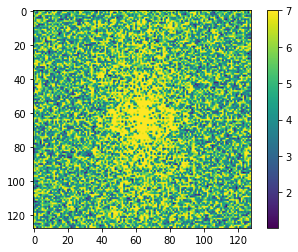

In [ ]:
plt.imshow(logdata[0][0])
plt.colorbar()

## set jVAE parameters and train:
* en_original_step_size: input image data size
* pool_list: pooling parameters for each maxpool layer
* embedding_size: number of embedding channels
* conv_size: number of filters for each CNN layer
* de_original_step_size: the original image size for the decoder to recover to the input image data size
* up_list: upsample parameters for each upsampling layer

In [ ]:
[xdim,ydim] = logdata.shape[-2:]

In [ ]:
en_original_step_size=[xdim,ydim]
pool_list=[4,4,2]

de_original_step_size = [8,8]
up_list = [2,2,4]
embedding_size=8
conv_size =128

batch_size=16

In [ ]:
encoder = Encoder(original_step_size=en_original_step_size,
                  pool_list=pool_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size).to(device)

decoder = Decoder(original_step_size=de_original_step_size,
                  up_list=up_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size).to(device)
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
train_iterator = DataLoader(logdata[:], batch_size=16,
                        shuffle=True)

In [ ]:
# load the trained weights. Do this if you want to start off from a specific epoch.

path_checkpoint = './BF_jVAE/(2022-03-30, 08:47)_epoch:00132_trainloss:0.3150_coef:5.2500E-08.pkl'


checkpoint = torch.load(path_checkpoint)  

model.load_state_dict(checkpoint['net'])
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
optimizer.load_state_dict(checkpoint['optimizer']) 
start_epoch = checkpoint['epoch']

date = re.split('/|_',path_checkpoint)[-4]+' '+re.split('/|_',path_checkpoint)[-3]
epoch,coef = re.split(':|_',path_checkpoint)[-5],re.split(':|_',path_checkpoint)[-1][:-4]

In [ ]:
coef, epoch = 0,0 # if you are training from scratch

epoch,coef = re.split(':|_',path_checkpoint)[-5],re.split(':|_',path_checkpoint)[-1][:-4] # if you are loading from a checkpoint
folder = make_folder(f)

if epoch<20: 
    while epoch<20:
        Train(model,encoder,decoder,train_iterator,optimizer,epochs=2000,coef=coef,epoch_=epoch,folder=folder)
        epoch = epoch+1
        
for i in range(1000): # stop when you see small difference in loss
    if i%5==0: coef+=2.5e-8
    Train(model,encoder,decoder,train_iterator,optimizer,2000,coef=coef,epoch_=epoch,folder=folder)
    epoch = epoch+1

# Load the model weights and show results

In [ ]:
pwd

'/content/drive/MyDrive/BTO_4DSTEM/BF'

In [ ]:
[xdim,ydim] = logdata.shape[-2:]

In [ ]:
en_original_step_size=[xdim,ydim]
pool_list=[4,4,2]

de_original_step_size = [8,8]
up_list = [2,2,4]
embedding_size=8
conv_size =128

batch_size=16

In [ ]:
encoder = Encoder(original_step_size=en_original_step_size,
                  pool_list=pool_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size).to(device)

decoder = Decoder(original_step_size=de_original_step_size,
                  up_list=up_list,
                  embedding_size=embedding_size,
                  conv_size=conv_size).to(device)
model = VAE(encoder, decoder).to(device)

# optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [ ]:
# load the trained weights

path_checkpoint = './BF_jVAE/(2022-03-30, 08:47)_epoch:00132_trainloss:0.3150_coef:5.2500E-08.pkl'


checkpoint = torch.load(path_checkpoint)  

model.load_state_dict(checkpoint['net'])
encoder.load_state_dict(checkpoint['encoder'])
decoder.load_state_dict(checkpoint['decoder'])
optimizer.load_state_dict(checkpoint['optimizer']) 
start_epoch = checkpoint['epoch']

date = re.split('/|_',path_checkpoint)[-4]+' '+re.split('/|_',path_checkpoint)[-3]
date = re.split('/|_',path_checkpoint)[-4]+' '+re.split('/|_',path_checkpoint)[-3]
h_dataset_name = f'{date} embedding'
h_transforms_name = f'{date} transforms'

In [ ]:
model.to(device);
encoder.to(device);
decoder.to(device);

## calculate embeddings

In [ ]:
train_iterator = DataLoader(logdata, batch_size=batch_size,
                        shuffle=False)

embedding_ = np.zeros([data.shape[0],embedding_size])
rotation_ = np.zeros([data.shape[0],6])
translation_ = np.zeros([data.shape[0],6])
scaling_ = np.zeros([data.shape[0],6])

In [ ]:
# calculate embeddings and transformations
# calculate embeddings and transformations
h = h5py.File(emb,'a')

j = 0
for i, x in enumerate(tqdm(train_iterator)):
    if h_dataset_name not in h.keys(): h_write_e = h.create_dataset(h_dataset_name,(logdata.shape[0],4,embedding_size),dtype='f4')
    h_write_e=h[h_dataset_name]
    
    if h_transforms_name not in h.keys(): h_write_t = h.create_dataset(h_transforms_name,(logdata.shape[0],3,6),dtype='f4')   
    h_write_t=h[h_transforms_name]
       
    with torch.no_grad():
        value = x
        test_value = Variable(value.to(device))
        test_value = test_value.float()
        #    result,a,b,c = model(test_value)
        encoded = encoder(test_value)
        b_len = x.shape[0]
#         print(i,x.shape, encoded[0].shape)
        
        embedding = encoded[0].squeeze().to('cpu').detach().numpy()
        h_write_e[i*b_len:(i+1)*b_len] = embedding
    
        rotation = encoded[1].reshape(b_len,6).to('cpu').detach().numpy()
        scaling = encoded[2].reshape(b_len,6).to('cpu').detach().numpy()
        translation = encoded[3].reshape(b_len,6).to('cpu').detach().numpy()
        h_write_t[i*b_len:(i+1)*b_len] = np.stack([rotation,translation,scaling],axis=1)
        
        j=j+1
print(j)
h.close()

7406it [03:00, 41.09it/s]

7406


## Show the embedding and reconstruction and make movie

In [ ]:
h = h5py.File(emb,'a')
h.keys()

<KeysViewHDF5 []>

In [ ]:
embedding_1 = h[h_dataset_name][:].reshape(t_len,a,b,-1)

NameError: ignored

In [ ]:
rotation_1 = h[h_transforms_name][0].reshape(t_len,a,b,-1)
translation_1 = h[h_transforms_name][1].reshape(t_len,a,b,-1)
scaling_1 = h[h_transforms_name][2].reshape(t_len,a,b,-1)

In [ ]:
xyscaling = np.zeros((t_len,a,b))
rotations = np.zeros((t_len,a,b))
translations = np.zeros((t_len,a,b))

for t in range(t_len):
    for i in range(a):
        for j in range(b):
            
            acos = np.arccos(rotation_1[t,i,j,0])
            asin = np.arcsin(rotation_1[t,i,j,3])

            if acos>0:
                if asin<0: theta = 2*np.pi+asin
                else: theta = asin
            if acos<0:
                if asin<0: theta = theta = np.pi-asin
                else: theta = acos

            rotations[t,i,j] = theta
            xyscaling[t,i,j] = np.sqrt(np.square(scaling_1[t,i,j,0]) + np.square(scaling_1[t,i,j,4]))
            translations[t,i,j] = np.sqrt(np.square(translation_1[t,i,j,2]) + np.square(translation_1[t,i,j,5]))

In [ ]:
fig, axes = plt.subplots(nrows=1,ncols=4,figsize=(16,4))

axes[0].set_title('Embedding')
axes[0].hist(embedding_1.flatten())

axes[1].set_title('Scaling')
axes[1].hist(scaling_1.flatten())

axes[2].set_title('Rotation')
axes[2].hist(rotation_1.flatten())

axes[3].set_title('Translation')
axes[3].hist(translation_1.flatten())

plt.tight_layout()

In [ ]:
max_e,min_e = embedding_1.max(),embedding_1.min()
max_s,min_s = xyscaling.max(), scaling_1.min()
max_t,min_t = translation_1.max(), translation_1.min()
folder = make_folder(f'./BF_jVAE/{date} combined/')

In [ ]:
import io
import PIL


# make images of embeddings+original image
for t,temp in enumerate(tqdm(temps)):
    title = re.split('/|\.',temp)[-3]+'_'+re.split('/|\.',temp)[-2]
    orig = hf['All'][t]


    fig = plt.figure(figsize=(24,16))
    gs = fig.add_gridspec(4,6)
    axs = []
    axs.append( fig.add_subplot(gs[:,:2]) ) # large subplot (2 rows, 2 columns)
    axs.append( fig.add_subplot(gs[:,2:4]) ) # large subplot (2 rows, 2 columns)
    axs.append( fig.add_subplot(gs[:,4:6]) ) # large subplot (2 rows, 2 columns)
    fig.suptitle({title})
    # for i in range(4):
    #     for j in range(1,3):
    #         axs.append( fig.add_axes(gs[i:i+1,j:j+1]) )   # small subplot (1st row, 3rd column)

    # for i in [0,1,2]:
    #     for j in [4,5]:
    #         axs.append(fig.add_subplot(gs[i:i+1,j:j+1]))

    axs[0].set_title('Full Image')
    a0 = axs[0].imshow(orig)
    divider = make_axes_locatable(axs[0])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(a0, cax=cax, orientation='vertical', pad = 0.2)
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')


    #Embeddings

    axs[1].set_title('Embeddings')
    axs[1].axis('off')
    fig_e, axes_e = layout_fig(embedding_size, mod=2);
    for j, axe in enumerate(axes_e):
        ax=axe.imshow(embedding_1[t,:,:,j].T,vmin=min_e,vmax=max_e)
        divider = make_axes_locatable(axe)
        cax = divider.append_axes('right', size='5%')
        cb=fig.colorbar(ax, cax=cax, orientation='vertical')
        cb.ax.xaxis.set_ticks_position('top')
        cb.ax.xaxis.set_label_position('top')
    fig_e.tight_layout();
    img_buf = io.BytesIO()
    fig_e.savefig(img_buf,bbox_inches='tight',format='png')
    im = PIL.Image.open(img_buf)
    axs[1].imshow(im)
    img_buf.close()


    #Transforms

    axs[2].set_title('Transforms')
    axs[2].axis('off')
    fig_t, axes = layout_fig(6, mod=2)
    title = re.split('/|\.',temp)[-3]+'_'+re.split('/|\.',temp)[-2]

    ax=axes[0].imshow(scaling_1[t,:,:,0].T,vmin=min_s,vmax=max_s);
    axes[0].set_title('x scaling')
    divider = make_axes_locatable(axes[0])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(ax, cax=cax, orientation='vertical')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')

    ax=axes[1].imshow(scaling_1[t,:,:,4].T,vmin=min_s,vmax=max_s);
    axes[1].set_title('y scaling')
    divider = make_axes_locatable(axes[1])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(ax, cax=cax, orientation='vertical')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    plt.tight_layout()

    ax=axes[2].imshow(xyscaling[t].T,vmin=min_s,vmax=max_s);
    axes[2].set_title('combined scaling')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(ax, cax=cax, orientation='vertical')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    plt.tight_layout()

    ax=axes[3].imshow(rotations[t].T);
    axes[3].set_title('rotation (rad)')
    divider = make_axes_locatable(axes[3])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(ax, cax=cax, orientation='vertical')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    plt.tight_layout()

    ax=axes[4].imshow(translation_1[t,:,:,2].T,vmin=min_t,vmax=max_t);
    axes[4].set_title('x translation')
    divider = make_axes_locatable(axes[4])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(ax, cax=cax, orientation='vertical')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    plt.tight_layout()

    ax=axes[5].imshow(translation_1[t,:,:,5].T,vmin=min_t,vmax=max_t);
    axes[5].set_title('y translation')
    divider = make_axes_locatable(axes[5])
    cax = divider.append_axes('right', size='5%')
    cb=fig.colorbar(ax, cax=cax, orientation='vertical')
    cb.ax.xaxis.set_ticks_position('top')
    cb.ax.xaxis.set_label_position('top')
    plt.tight_layout()

    fig_t.tight_layout();
    img_buf = io.BytesIO()
    fig_t.savefig(img_buf,bbox_inches='tight',format='png')
    im = PIL.Image.open(img_buf)
    axs[2].imshow(im)
    img_buf.close()


    fig.tight_layout()
    fig.savefig(folder+f'{t:02d}.png',facecolor='white');


In [ ]:
make_movie('combined',
           folder,
           folder,
           'png',
          3)

In [ ]:
embedding_1.shape

In [ ]:
# threshholding

from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)


image = embedding_1[0,:,:,0]
binary_global = image > threshold_otsu(image)

window_size = 25
thresh_niblack = threshold_niblack(image, window_size=window_size, k=0.8)
thresh_sauvola = threshold_sauvola(image, window_size=window_size)

binary_niblack = image > thresh_niblack
binary_sauvola = image > thresh_sauvola

plt.figure(figsize=(8, 7))
plt.subplot(2, 2, 1)
plt.imshow(image, cmap=plt.cm.gray)
plt.title('Original')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.title('Global Threshold')
plt.imshow(binary_global, cmap=plt.cm.gray)
plt.axis('off')

plt.subplot(2, 2, 3)
plt.imshow(binary_niblack, cmap=plt.cm.gray)
plt.title('Niblack Threshold')
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(binary_sauvola, cmap=plt.cm.gray)
plt.title('Sauvola Threshold')
plt.axis('off')

plt.show()

# analyze embeddings

## Label embeddings with orientation names

* count number of orientations and label as string
* before forming the mask, you may need to play aroudn with some of the embeddings. For instance, dividing an embedding by the warping, or by a very bright embedding to segment out other areas.
* maybe best to do each embedding separately

## make masks
* pick out layer with warping. divide all imgs by it to get rid of warping a bit
* if mean>0.5, use global threshold. else, use threshold = mean+2*std

In [ ]:
# label and channel number manually.
emb_dict = {'-45': 4,'0': 0,'45': 7,'90':6}

In [ ]:
emb_dict.values()

dict_values([4, 0, 7, 6])

In [ ]:
from skimage import morphology
from skimage.filters import threshold_otsu

def make_mask(timage_idx, warp_idx):
    '''
    prints image, warp, histogram, and mask
    image: 2D embedding channel to make a mask of.
    warp: 2D embedding channel with the warp instead of the feature
    ---
    returns: mask
    '''
    warp=embedding_1[0,:,:,3]
    warp/=warp.max()
    image = ch0/(warp+1)
    image = image/image.max()


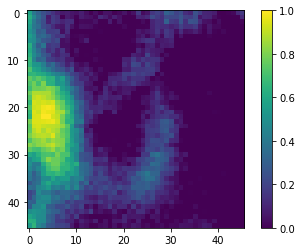

In [ ]:
warp=embedding_1[0,:,:,3]
warp/=warp.max()
plt.imshow(warp)
plt.colorbar()

In [ ]:
warp/=warp.max()

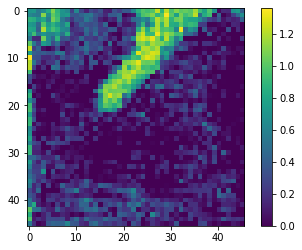

In [ ]:
ch0 = embedding_1[0,:,:,0]
plt.imshow(ch0)
plt.colorbar()

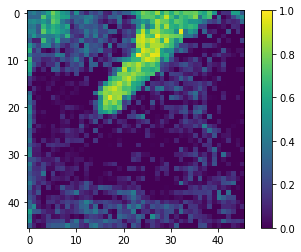

In [ ]:
image = ch0/(warp+1)
image = image/image.max()
plt.imshow(image)
plt.colorbar()

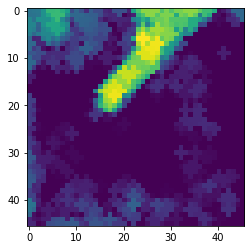

In [ ]:
proc=morphology.opening(image)
plt.imshow(proc)

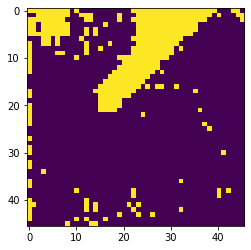

In [ ]:
binary_global = image > threshold_otsu(proc)
plt.imshow(binary_global)

In [ ]:
proc=binary_global

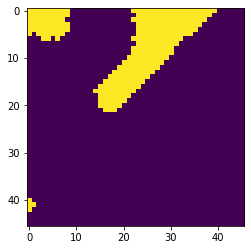

In [ ]:
proc = morphology.binary_opening(proc)
proc = morphology.binary_closing(proc)
plt.imshow(proc)

(array([1099.,  408.,  204.,  107.,   51.,   49.,   69.,   55.,   57.,
          17.]),
 array([0.        , 0.13588879, 0.27177757, 0.40766633, 0.54355514,
        0.6794439 , 0.81533265, 0.95122147, 1.0871103 , 1.222999  ,
        1.3588878 ], dtype=float32),
 <BarContainer object of 10 artists>)

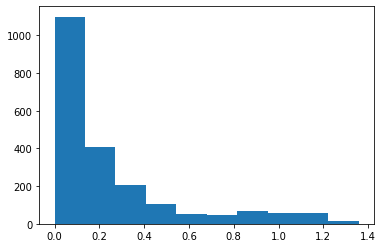

In [ ]:
# if the distribution is skewed, use otsu?
plt.hist(image.flatten())

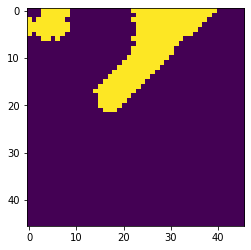

In [ ]:
binary_global = image > threshold_otsu(image)
proc = morphology.binary_opening(binary_global)
proc = morphology.binary_closing(proc)
plt.imshow(proc)

## ch 4

In [ ]:
mean,std = np.mean(image.flatten()),np.std(image.flatten())
mean,std

(0.50400937, 0.24239145)

In [ ]:
mean+std*2

0.9887922704219818

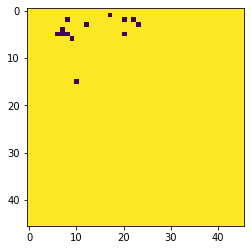

In [ ]:
mask = image>(mean-std*2)
plt.imshow(mask)

In [ ]:
proc=morphology.binary_closing(mask,morphology.rectangle(3,8))
proc=morphology.binary_closing(proc,morphology.rectangle(3,8))

In [ ]:
proc=morphology.binary_closing(mask,morphology.disk(5))
proc=morphology.binary_closing(proc,morphology.disk(5))

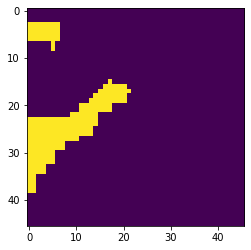

In [ ]:
plt.imshow(proc)

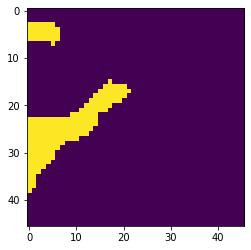

In [ ]:
proc2=morphology.binary_opening(proc)
plt.imshow(proc2)

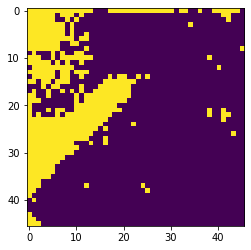

In [ ]:
proc[]
plt.imshow(proc)

In [ ]:
threshold_otsu(image)

0.5016207